## Rounded Micro Domain

The micro domain is defined by a bounding box and a smooth function parameterising the floor of the micro domain. 

In [9]:
import sys
import torch
from boundary_solvers.gauss_grid_2d import *
from boundary_solvers.geometry import *
import numpy as np
import matplotlib.pyplot as plt
from util.plot_tools import *
from boundary_solvers.blobs import *
import os


path_data = "/home/emastr/github/deep-micro-slip-model/data"
path_geometries = "/home/emastr/github/deep-micro-slip-model/data/micro_geometries_boundcurv_test/"
path_torch = "/home/emastr/deep-micro-slip-model/data/micro_geometries_boundcurv_repar_256_test/"

os.makedirs(path_data, exist_ok=True)
os.makedirs(path_geometries, exist_ok=True)
os.makedirs(path_torch, exist_ok=True)


## Generating a data set

In [16]:
np.random.seed(0)
N = 200
plt.figure(figsize=(15,15))
riesz = []
zvec = []

worst_error = 0.
worst_idx = 0

default_parameters = {"kernel": "exp", "shape":.05, "num":20, "scale":.05, "bound":.3, "verbose": False, "width":1, "height":1, "corner_w":0.3, "line_pos":0.1, "n_refine":2, "n_corner_refine":0}
#randomisers = {"width": lambda: 0.5 + np.random.rand()*0.5, "scale": lambda: 0.01 + 10 ** (-np.random.rand()-1), "height": lambda: 0.5 + np.random.rand()*0.5, "corner_w": lambda: np.random.rand()*0.3 + 0.1, "line_pos": lambda: np.random.rand()*0.2 + 0.05}
randomisers = {"width": lambda: 0.2 + np.random.rand()*1., 
               "scale": lambda: 10**(-0.4-1.*np.random.rand()),#0.01 + 10 ** (-np.random.rand()-1), 
               "height": lambda: 0.7 + np.random.rand()*0.5, 
               "corner_w": lambda: np.random.rand()*0.2 + 0.1, 
               "line_pos": lambda: np.random.rand()*0.1 + 0.00}
to_randomise = ["height", "corner_w", "line_pos", "scale"]
#to_randomise = ["height", "line_pos", "corner_w"]
#to_randomise = ["line_pos"]
i = 0
while i < N:
    kwargs = {**default_parameters}
    for key in to_randomise:
        kwargs[key] = randomisers[key]()
    try:
        mg = GPDomain(**kwargs)
        
        r1, func = mg.precompute_line_avg(derivative=0, tol=1e-12, maxiter=200, verbose=False)
        r2, _    = mg.precompute_line_avg(derivative=1, tol=1e-12, maxiter=200, verbose=False)
        r3, _    = mg.line_eval_adjoint(derivative=0, tol=1e-12, maxiter=200, verbose=False)
        r4, _    = mg.line_eval_adjoint(derivative=1, tol=1e-12, maxiter=200, verbose=False)
        
        
        c = 1j + 1
        vec = np.conjugate(mg.eval_param()) - c
        a = mg.line_left - c
        b = mg.line_right - c
        
        num = func(vec)
        tru = np.real(b**2 - a**2)/2
        dif = abs(num - tru)
        worst_error = max(worst_error, dif)
        worst_idx = i if dif == worst_error else worst_idx
        print(f"{i+1}/{N} done. TEST > numerical: {num:.2f}, true: {tru:.2f}, difference: {dif:.2e}, worst: {worst_error:.2e}, idx: {worst_idx}", end="\r")
        
        mg.data["precomp"]     = r1
        mg.data["precomp_der"] = r2
        mg.data["intermediate_precomp"] = r3
        mg.data["intermediate_precomp_der"] = r4
        mg.data["error"] = dif
        
        assert dif < 1e-4
        
        #mg.plot(ax=plt.gca(), shownormals=True, showpts=True, npts=500)
        #mg.plot(ax=plt.gca(), npts=300)
        
        mg.save(f"{path_geometries}/domain_{i}.GPDomain")
        i = i + 1
    except:
        pass

<Figure size 1500x1500 with 0 Axes>

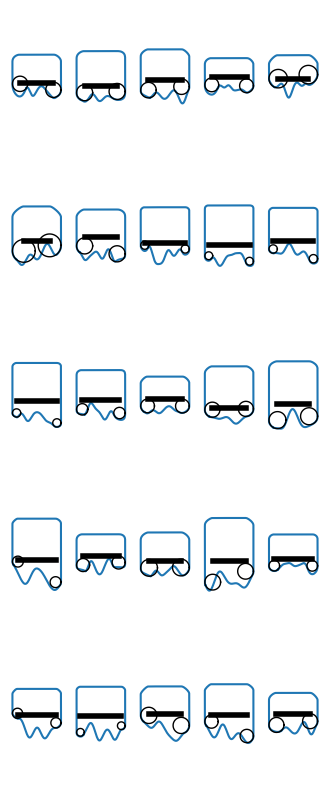

In [17]:
plt.figure(figsize=(4,10))
n = 5
i0 = 0
for i in range(n*n):
    plt.subplot(n,n, i+1)
    data = torch.load(f"{path_geometries}/domain_{i0 + i}.GPDomain")
    data.pop("precomp")
    data.pop("precomp_der")
    data.pop("intermediate_precomp")
    data.pop("intermediate_precomp_der")
    data.pop("error")
    
    GPDomain.load(data).plot(ax=plt.gca(), npts=300, show_samples=False, show_rounded=True)
    remove_axes(plt.gca())
    #plt.plot([-1,1], [0,0], "k--")
    plt.xlim([-1.2,1.2])
    plt.ylim([-1.0,1.3])
    plt.axis("equal")
    #plt.axis("equal")

# Convert to PyTorch Tensor

### Reparameterisation + Coordinate tfm

In [15]:
from scipy.interpolate import interp1d

def reparameterize_data(t, dt, data, M=None):
    """Reparameterize the data to be a function of t in [0,1].
    Uses fouier series with 2*k_max+1 terms."""    
    #dtype = torch.complex64

    if M is None:
        M = len(t)
    data_np = data.numpy()
    t_np = t
    f = interp1d(t_np, data_np, axis=-1)
    t_np = np.linspace(0, 2*np.pi, M+1)[:-1]
    data_np = f(t_np)
    
    return torch.from_numpy(data_np)

# 200 000 data points, we run through
N = 200
M = 512#512
reparameterize = "arclen" # uniform / arclen
Mout = 256
err = []
idx = []

for j in range(1):
    start = j * N
    

    in_ch = ["zr", "zi", "dzr", "dzi", "ddzr", "ddzi", "inter_precomp_r", "inter_precomp_i", "inter_precomp_der_r", "inter_precomp_der_i", "w", "t"]
    out_ch = ["precomp_r", "precomp_i", "precomp_der_r", "precomp_der_i"]

    in_data = torch.zeros(N, len(in_ch), M)
    out_data = torch.zeros(N, len(out_ch), M)

    in_tmp = torch.zeros(N, len(in_ch), Mout)
    out_tmp = torch.zeros(N, len(out_ch), Mout)
    
    for i in range(N):
        print(f"{start + i + 1}/{20000} done", end="\r")
        data = torch.load(f"{path_geometries}/domain_{start + i}.GPDomain")
        precomp = data.pop("precomp")
        inter_precomp = data.pop("intermediate_precomp")
        precomp_der = data.pop("precomp_der")
        inter_precomp_der = data.pop("intermediate_precomp_der")
        
        err.append(data.pop("error"))
        idx.append(start + i)
        
        geom = GPDomain.load(data)
        t, w = geom.grid.get_grid_and_weights()
        z = geom.eval_param(derivative=0)
        dz = geom.eval_param(derivative=1)
        ddz = geom.eval_param(derivative=2)

        #n = dz/np.abs(dz)
        #r = np.imag(dz * np.conjugate(ddz))/np.abs(dz)**3 * n

        # Set in data
        in_data[i, 0, :] = torch.from_numpy(np.real(z))
        in_data[i, 1, :] = torch.from_numpy(np.imag(z))
        in_data[i, 2, :] = torch.from_numpy(np.real(dz))
        in_data[i, 3, :] = torch.from_numpy(np.imag(dz))
        in_data[i, 4, :] = torch.from_numpy(np.real(ddz))
        in_data[i, 5, :] = torch.from_numpy(np.imag(ddz))
        in_data[i, 6, :] = torch.from_numpy(np.real(inter_precomp))
        in_data[i, 7, :] = torch.from_numpy(np.imag(inter_precomp))
        in_data[i, 8, :] = torch.from_numpy(np.real(inter_precomp_der))
        in_data[i, 9, :] = torch.from_numpy(np.imag(inter_precomp_der))
        in_data[i, 10, :] = torch.from_numpy(w)
        in_data[i, 11, :] = torch.from_numpy(t)

        # set out data
        out_data[i, 0, :] = torch.from_numpy(np.real(precomp))
        out_data[i, 1, :] = torch.from_numpy(np.imag(precomp))
        out_data[i, 2, :] = torch.from_numpy(np.real(precomp_der))
        out_data[i, 3, :] = torch.from_numpy(np.imag(precomp_der))


        if reparameterize == "arclen":
            dt = np.zeros_like(t)
            dt[:-1] = t[1:] - t[:-1]
            dt[-1] = 2*np.pi - t[-1]
            l = np.cumsum(np.abs(dz) * dt)
            L = l[-1]
            l = np.roll(l, 1) / L *2*np.pi
            l[0] = 0.
            dl = np.abs(dz) * 2*np.pi / L * dt
            
            out_tmp[i, :, :] = reparameterize_data(l, dl, out_data[i, :, :], M=Mout)
            in_tmp[i, :, :] = reparameterize_data(l, dl, in_data[i, :, :], M=Mout)
            in_tmp[i, -1, :] = torch.linspace(0, 2*np.pi, Mout+1)[:-1]
            in_tmp[i, -2, :] = torch.ones(Mout) * 2*np.pi / Mout
        
        if reparameterize == "uniform":
            dt = np.zeros_like(t)
            t_ext = np.concatenate([t-2*np.pi, t, t+2*np.pi])
            out_ext = torch.cat((out_data[i, :, :], out_data[i, :, :], out_data[i, :, :]), dim=1)
            inp_ext = torch.cat((in_data[i, :, :], in_data[i, :, :], in_data[i, :, :]), dim=1)

            out_tmp[i, :, :] = reparameterize_data(t_ext, dt, out_ext, M=Mout)
            in_tmp[i, :, :] = reparameterize_data(t_ext, dt, inp_ext, M=Mout)
            in_tmp[i, -1, :] = torch.linspace(0, 2*np.pi, Mout+1)[:-1]
            in_tmp[i, -2, :] = torch.ones(Mout) * 2*np.pi / Mout
        
    out_data = out_tmp
    in_data = in_tmp
    data = {"X": in_data, "Y": out_data, "info": {"in_ch": in_ch, "out_ch": out_ch}}
    torch.save(data, f"{path_torch}data_big_{j}.torch")    
    print(f"saved {j}") #breakb


saved 00 done


In [ ]:
data_new = torch.load(f"{path_torch}data_big_{0}.torch")
X = data_new['X']
Y = data_new['Y']
mask = torch.isnan(Y).any(dim=(1,2))
X = X[~mask]
Y = Y[~mask]
torch.save({'X': X, 'Y': Y, 'info': data_new['info']}, f"{path_torch}data_big_clean.torch")
print(data_new['info'])
print(X.shape)

{'in_ch': ['zr', 'zi', 'dzr', 'dzi', 'ddzr', 'ddzi', 'inter_precomp_r', 'inter_precomp_i', 'inter_precomp_der_r', 'inter_precomp_der_i', 'w', 't'], 'out_ch': ['precomp_r', 'precomp_i', 'precomp_der_r', 'precomp_der_i']}
torch.Size([20000, 12, 256])


In [ ]:
N = 2000
M = 512
reparameterize = False
err = []
idx = []

for j in range(2):
    start = j * N
    

    in_ch = ["zr", "zi", "dzr", "dzi", "ddzr", "ddzi", "inter_precomp_r", "inter_precomp_i", "inter_precomp_der_r", "inter_precomp_der_i", "w", "t"]
    out_ch = ["precomp_r", "precomp_i", "precomp_der_r", "precomp_der_i"]

    in_data = torch.zeros(N, len(in_ch), M)
    out_data = torch.zeros(N, len(out_ch), M)
    
    for i in range(N):
        print(f"{start + i + 1}/{20000} done", end="\r")
        data = torch.load(f"{path_geometries}/domain_{start + i}.GPDomain")
        err.append(data.pop("error"))
        idx.append(j*N + i)

9.911398841411234e-05


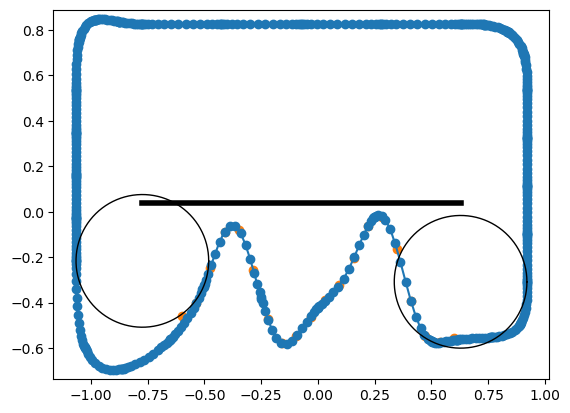

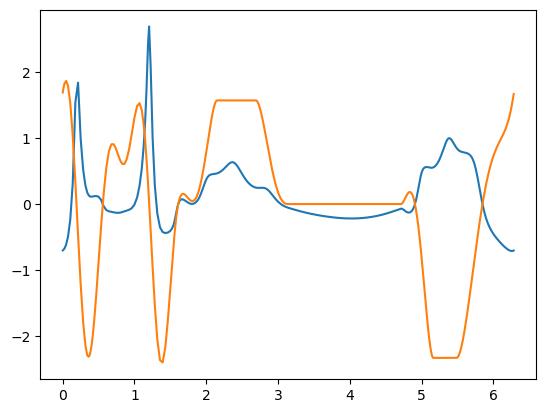

In [ ]:
idx_max = idx[np.argsort(err)[-1]]
#plt.plot(idx, err)
data = torch.load(f"{path_geometries}/domain_{idx_max}.GPDomain")
r = data.pop("precomp")
data.pop("intermediate_precomp")
data.pop("precomp_der")
data.pop("intermediate_precomp_der")
print(data.pop("error"))

geom = GPDomain.load(data)
geom.plot(ax=plt.gca(), showpts=True)
plt.axis("equal")

plt.figure()
t, _ = geom.grid.get_grid_and_weights()
z = geom.eval_param(derivative=1)
plt.plot(t, r.imag)
plt.plot(t, z.imag)


### Symmetries

* Output is invariant to rescaling
* Output is equivariant to rotation

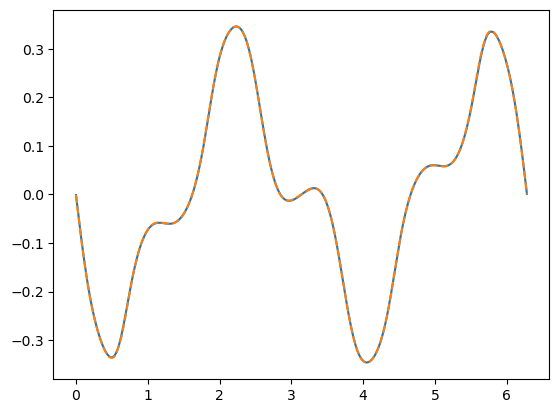

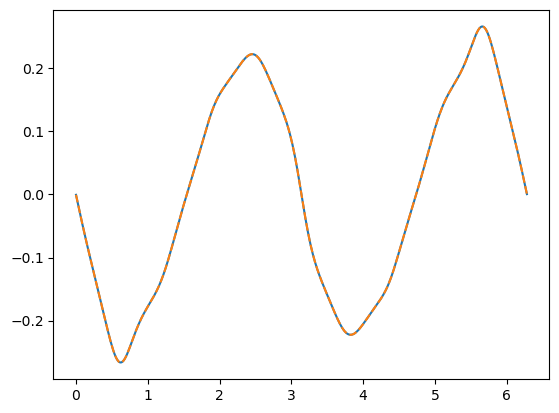

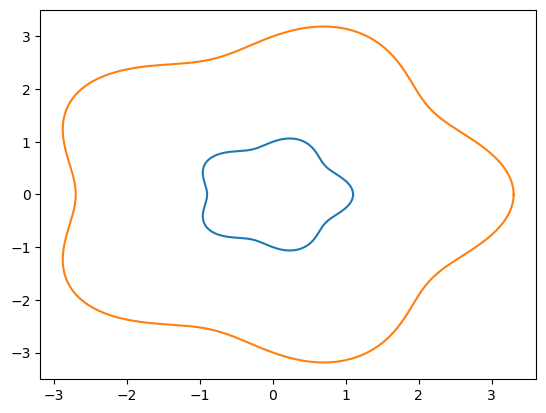

In [ ]:
grid = GaussLegGrid(np.array([0, 2*np.pi]))
grid.refine_all_nply(5)


z = lambda t: np.exp(1j*t) * (1 + 0.1*np.cos(5*t))
dz = lambda t: 1j*np.exp(1j*t) * (1 + 0.1*np.cos(5*t)) - 0.5*np.exp(1j*t)*np.sin(5*t)
ddz = lambda t: -np.exp(1j*t) * (1 + 0.1*np.cos(5*t)) - 0.5j*np.exp(1j*t)*np.sin(5*t) - 2.5*np.exp(1j*t)*np.cos(5*t)

s = 3.
t, _ = grid.get_grid_and_weights()
geom = Geometry([z, dz, ddz], grid)
geom_scale = Geometry([lambda t: s*z(t), lambda t: s*dz(t), lambda t: s**2*ddz(t)], grid)

avg_pre, _ = geom.line_eval_adjoint(-0.4, 0.4, derivative=0, tol=1e-12, maxiter=200, verbose=False)
avg, _ = geom.precompute_line_avg(-0.4, 0.4, derivative=0, tol=1e-12, maxiter=200, verbose=False)

avg_pre_scale, _ = geom_scale.line_eval_adjoint(-0.4*s, 0.4*s, derivative=0, tol=1e-12, maxiter=200, verbose=False)
avg_scale, _ = geom_scale.precompute_line_avg(-0.4*s, 0.4*s, derivative=0, tol=1e-12, maxiter=200, verbose=False)

plt.figure()
plt.plot(t, avg.real)
plt.plot(t, avg_scale.real, '--')

plt.figure()
plt.plot(t, avg_pre.real)
plt.plot(t, avg_pre_scale.real, '--')

plt.figure()
geom.plot(plt.gca())
geom_scale.plot(plt.gca())